In [1]:
# Utils
# ==============================================================================
import warnings
from unicodedata import normalize

# Charts
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
# ==============================================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import (OneHotEncoder, TargetEncoder)
from sklearn.compose import ColumnTransformer

# Model
# ==============================================================================
from sklearn.model_selection import (
    train_test_split,
    RepeatedKFold,
    cross_val_score)
from xgboost import XGBRegressor

# Metrics
# ==============================================================================
from sklearn.metrics import mean_absolute_error



# **INFO**
---

**@By**: Steven Bernal

**@Nickname**: Kaiziferr

**@Git**: https://github.com/Kaiziferr

# **CONFIG**
---

In [2]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
random_seed = 12354
warnings.filterwarnings("ignore")

# **FUNCTIONS**
---

In [3]:
def normalize_word(word)->str:
  """Normaliza palabras"""
  word = word.replace(' ', '_')
  find_guion = word.find('_')
  list_word = []
  if find_guion:
    list_word = [w for w in word.split('_') if w != '']
  else:
    list_word = word
  word = list(map(lambda x: x.lower(), list_word))
  word = [normalize('NFKD', c).encode('ASCII', 'ignore').decode() for c in word]
  word = "_".join(word)
  return word

def normalize_name_columns(columns):
  """Normaliza columnas"""
  columns = list(map(lambda x: normalize_word(x), columns))
  return columns

def null_percentage_per_feature(data:pd.DataFrame, **kwargs)->None:
    """Calculate the percentage of null values per feature"""
    try:
        ticklabels = data.isnull().melt().pipe(
            lambda df: (
                sns.displot(
                    data=df,
                    y='variable',
                    hue='value',
                    multiple='fill',
                    aspect=5
                    ).set(**kwargs)
                )
            )
        p = (data.isnull().sum()/data.shape[0])
        for n, i in zip(p.index, range(p.shape[0])):
            if p[i] > 0:
                ticklabels.ax.text(p[n]+0.015, i+0.2, f'{round(p[n]*100, 2)}%', ha="center", color='w', fontweight='bold')
    except Exception as e:
        print(e)


The purpose of this notebook is to understand how to apply learning curves to detect underfitting or overfitting. For the purposes of the project, it will focus more on tuning and curves rather than on complex preprocessing.

# **DATA**
---

In [4]:
url_master =  'https://drive.google.com/uc?id='
url_minero='https://drive.google.com/file/d/10_YGM_dOKzzLsLNkfB_bN5YeLgDHcrUZ/view?usp=sharing'

url_minero =  url_master + url_minero.split('/')[-2]
data_miner = pd.read_csv(url_minero, dtype=str)
data_miner.head(2)

,Municipio Productor,Departamento,Recurso Natural,Nombre Del Proyecto,Año Produccion,Trimestre,Unidad Medida,Tipo Contraprestacion,Valor Contraprestacion,Cantidad Producción
0,Medellin,Antioquia,ARCILLAS,PRODUCTORES,2018,Trimestre 4,TONELADAS,REGALIAS,614258,0
1,Medellin,Antioquia,ARCILLAS CERAMICAS,PRODUCTORES,2014,Trimestre 4,TONELADAS,REGALIAS,2036781,14381


In [5]:
data_miner.columns = normalize_name_columns(data_miner.columns)
data_miner.columns

Index(['municipio_productor', 'departamento', 'recurso_natural',
       'nombre_del_proyecto', 'ano_produccion', 'trimestre', 'unidad_medida',
       'tipo_contraprestacion', 'valor_contraprestacion',
       'cantidad_produccion'],
      dtype='object')

In [6]:
data_miner[[
    'valor_contraprestacion',
    'cantidad_produccion']] = data_miner[[
    'valor_contraprestacion',
    'cantidad_produccion']].astype('float64')
data_miner[
    'ano_produccion'] = data_miner[
    'ano_produccion'].astype('int64')

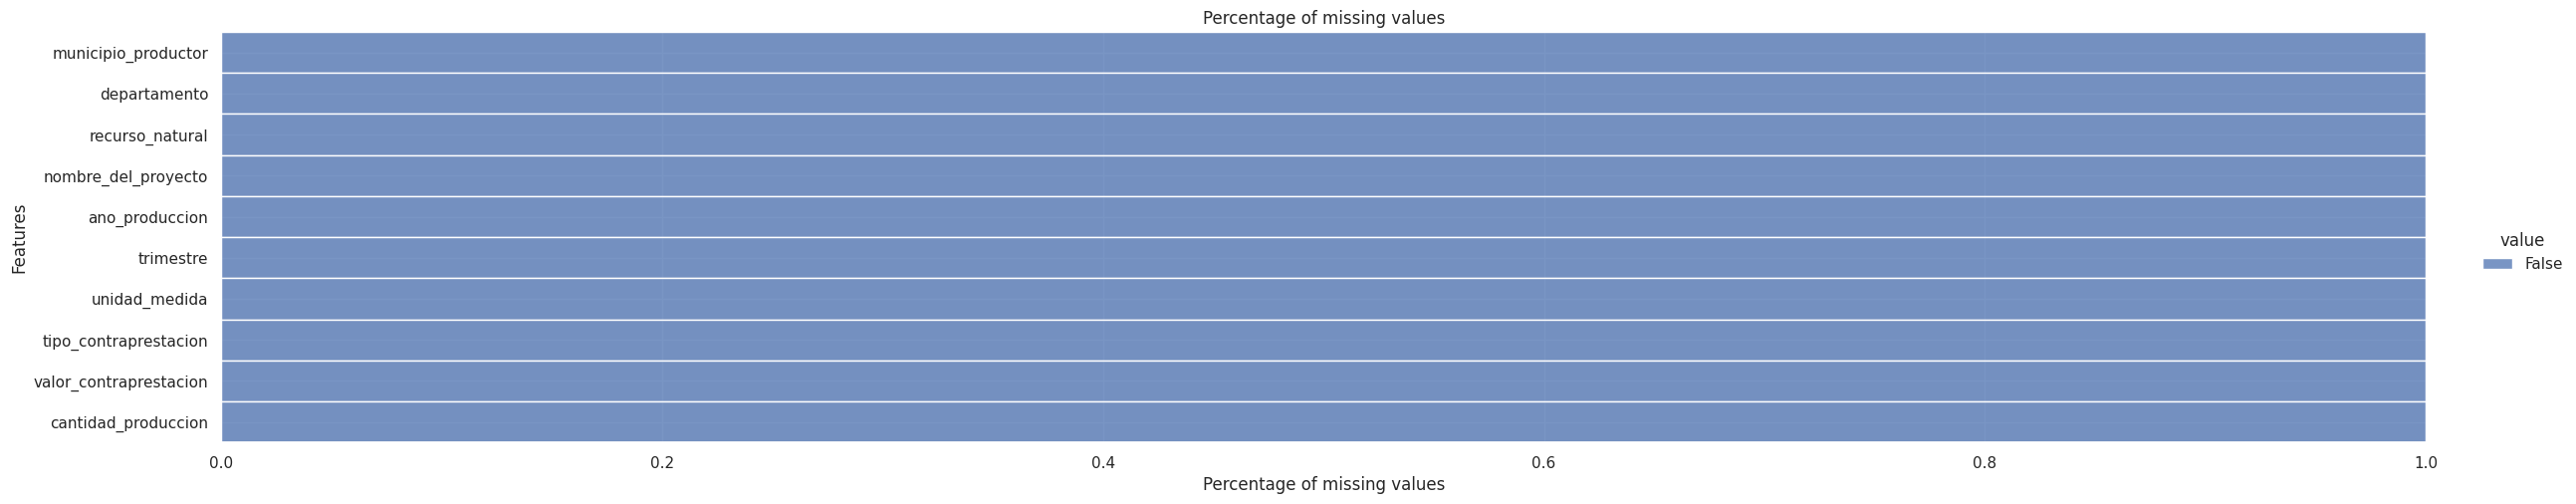

In [7]:
null_percentage_per_feature(
    data_miner,
    title="Percentage of missing values",
    xlabel='Percentage of missing values',
    ylabel='Features')

There are no null values

- Information from the last six years will be taken





In [8]:
data_miner = data_miner[
    (data_miner['ano_produccion'] > 2017)
    &
    (data_miner['ano_produccion'] < 2024)
]

In [9]:
data_miner['ano_produccion'].value_counts()

,count
ano_produccion,
2018,5305
2019,5133
2022,4150
2021,4141
2020,3965
2023,2355


In [10]:
data_miner.columns

Index(['municipio_productor', 'departamento', 'recurso_natural',
       'nombre_del_proyecto', 'ano_produccion', 'trimestre', 'unidad_medida',
       'tipo_contraprestacion', 'valor_contraprestacion',
       'cantidad_produccion'],
      dtype='object')

A first grouping is made with respect to the municipality, department, year of production, and quarter. To obtain the total value of the compensation, the number of transactions, and the amount of production.



In [11]:
function_dictionary = {
    'valor_contraprestacion':['sum', 'count'],
    'cantidad_produccion': ['sum'],
}

data_transaction = data_miner.groupby([
    'municipio_productor',
    'departamento',
    'ano_produccion',
    'trimestre'
]).aggregate(
    function_dictionary
)

data_transaction.columns = [
    'valor_contraprestacion_sum',
    'n_transacciones_valor_contraprestacion',
    'valor_cantidad_produccion_sum',
]

data_transaction.reset_index(inplace=True)
data_transaction

,municipio_productor,departamento,ano_produccion,trimestre,valor_contraprestacion_sum,n_transacciones_valor_contraprestacion,valor_cantidad_produccion_sum
0,Abejorral,Antioquia,2018,Trimestre 1,"2,783,489.00",1,"52,003.00"
1,Abejorral,Antioquia,2018,Trimestre 2,"3,659,452.00",1,"52,003.00"
2,Abejorral,Antioquia,2018,Trimestre 3,"5,732,763.00",1,"81,466.00"
3,Abejorral,Antioquia,2018,Trimestre 4,"11,706,438.00",2,"108,651.00"
4,Abejorral,Antioquia,2019,Trimestre 1,"5,793,131.00",2,"67,752.00"
...,...,...,...,...,...,...,...
9912,Zona Bananera,Magdalena,2020,Trimestre 4,"65,800.00",2,452.00
9913,Zona Bananera,Magdalena,2021,Trimestre 2,"76,600.00",2,526.00
9914,utica,Cundinamarca,2020,Trimestre 4,59.00,1,0.00
9915,utica,Cundinamarca,2021,Trimestre 4,77.00,1,0.00


Then, a second grouping is performed by producing municipalities and departments to obtain the total and quarterly average of the compensation value; the number of transactions and its quarterly average; the production quantity value and the average production per quarter; as well as the number of quarters and years of activity

In [12]:
function_dictionary = {
    'valor_contraprestacion_sum':['sum', 'mean'],
    'n_transacciones_valor_contraprestacion': ['sum', 'mean'],
    'valor_cantidad_produccion_sum': ['sum', 'mean'],
    'trimestre': ['count'],
    'ano_produccion': ['nunique'],
}


data_transaction_dos = data_transaction.groupby([
    'municipio_productor',
    'departamento',
]).aggregate(
    function_dictionary
)
data_transaction_dos.columns = [
    'valor_contraprestacion_sum',
    'valor_contraprestacion_mean',
    'n_transacciones_valor_contraprestacion_sum',
    'n_transacciones_valor_contraprestacion_mean',
    'valor_cantidad_produccion_sum',
    'valor_cantidad_produccion_mean',
    'n_trimestre',
    'n_ano_produccion'
]

data_transaction_dos.reset_index(inplace=True)
data_transaction_dos

,municipio_productor,departamento,valor_contraprestacion_sum,valor_contraprestacion_mean,n_transacciones_valor_contraprestacion_sum,n_transacciones_valor_contraprestacion_mean,valor_cantidad_produccion_sum,valor_cantidad_produccion_mean,n_trimestre,n_ano_produccion
0,Abejorral,Antioquia,"54,668,833.00","4,555,736.08",18,1.50,"518,259.00","43,188.25",12,5
1,Abrego,Norte de Santander,"22,530,021.00","1,408,126.31",21,1.31,"111,626.00","6,976.62",16,5
2,Abriaqui,Antioquia,"357,383,964.00","21,022,586.12",45,2.65,"69,276.00","4,075.06",17,6
3,Acacias,Meta,"677,940,389.00","30,815,472.23",63,2.86,"3,092,471.00","140,566.86",22,6
4,Achi,Bolivar,"2,940,415,573.00","588,083,114.60",18,3.60,"361,520.00","72,304.00",5,2
...,...,...,...,...,...,...,...,...,...,...
705,Zaragoza,Antioquia,"34,398,813,794.00","1,563,582,445.18",101,4.59,"13,096,108.00","595,277.64",22,6
706,Zarzal,Valle del Cauca,"13,253,174.00","736,287.44",22,1.22,"84,672.00","4,704.00",18,6
707,Zipaquira,Cundinamarca,"3,429,252,068.00","163,297,717.52",61,2.90,"1,193,980.00","56,856.19",21,6
708,Zona Bananera,Magdalena,"2,280,457.00","380,076.17",16,2.67,"15,294.00","2,549.00",6,4


Since there are similar municipalities in different departments, they are concatenate the features for create a new unique key



In [13]:
data_transaction_dos['id'] = data_transaction_dos.municipio_productor.str.cat(
    data_transaction_dos.departamento, sep='-'
)

data_transaction_dos = data_transaction_dos.drop(['municipio_productor', 'departamento'], axis=1)

In [14]:
data_transaction_dos = data_transaction_dos.iloc[:, ::-1]
data_transaction_dos.head(3)

,id,n_ano_produccion,n_trimestre,valor_cantidad_produccion_mean,valor_cantidad_produccion_sum,n_transacciones_valor_contraprestacion_mean,n_transacciones_valor_contraprestacion_sum,valor_contraprestacion_mean,valor_contraprestacion_sum
0,Abejorral-Antioquia,5,12,"43,188.25","518,259.00",1.50,18,"4,555,736.08","54,668,833.00"
1,Abrego-Norte de Santander,5,16,"6,976.62","111,626.00",1.31,21,"1,408,126.31","22,530,021.00"
2,Abriaqui-Antioquia,6,17,"4,075.06","69,276.00",2.65,45,"21,022,586.12","357,383,964.00"


# **Data Split**
---

A split is generated to divide the training and validation data



In [15]:
X = data_transaction_dos.drop(['id','valor_contraprestacion_sum'], axis=1)
y = data_transaction_dos['valor_contraprestacion_sum']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=random_seed,
    test_size=0.25
)

**Model**
---

A XGBRegressor model is instantiated and tuned



In [17]:
model = XGBRegressor(
    n_estimators = 200,
    max_depth = 7,
    eta = 0.1,
    subsample = 1,
    colsample_bytree = 1,
    alpha = 5,
    eval_metric = mean_absolute_error
)

In [18]:
model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=0)

XGBRegressor(alpha=5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eta=0.1,
             eval_metric=<function mean_absolute_error at 0x7b0894a651c0>,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, ...)

The lists containing the training and validation error metrics are accessed in each iteration.

In [19]:
results = model.evals_result()
results.keys()

dict_keys(['validation_0', 'validation_1'])

In this graph, it is evident that the model has convergence at tree 75 with the configuration hyperparameters in the second instance of the model.



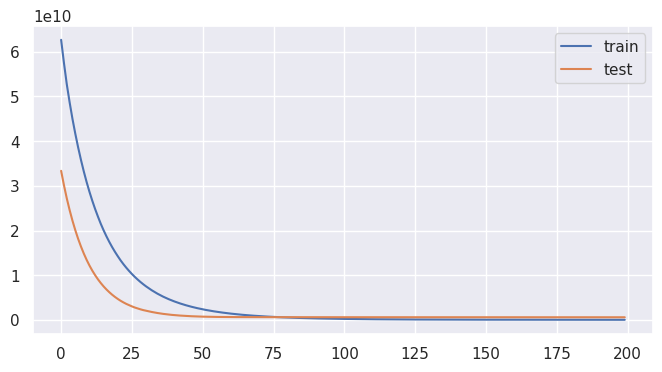

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(results['validation_0']['mean_absolute_error'], label='train')
ax.plot(results['validation_1']['mean_absolute_error'], label='test')
plt.legend()
plt.show()

The model was configured with 75 estimators, along with parameter settings, as there is a convergence between the error on the training data and the validation data.

In [21]:
model = XGBRegressor(
    n_estimators = 75,
    max_depth = 7,
    eta = 0.1,
    subsample = 1,
    colsample_bytree = 1,
    alpha = 5,
    eval_metric = mean_absolute_error
)

In [22]:
model.fit(X_train, y_train)

XGBRegressor(alpha=5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eta=0.1,
             eval_metric=<function mean_absolute_error at 0x7b0894a651c0>,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=75, ...)

Using the 10-fold CV technique, the error is calculated using the neg_mean_absolute_error metric



In [23]:
cv = RepeatedKFold(
    n_splits=10,
    n_repeats=3,
    random_state=random_seed
)


scores = cross_val_score(
    model,
    X,
    y,
    scoring = 'neg_mean_absolute_error',
    cv = cv,
    n_jobs = -1
)

In [24]:
scores = np.absolute(scores)

In [25]:
print('Mean MAE: {:0,.0f}, Std: {:0,.0f}'.format(scores.mean(), scores.std()))

Mean MAE: 25,204,989,981, Std: 37,915,357,532


The error is 25,204,989,981 and it is above the 75th percentile.



In [26]:
y.describe()

,valor_contraprestacion_sum
count,710.00
mean,"29,244,575,006.88"
std,"371,166,053,278.03"
min,77.00
25%,"7,931,449.75"
50%,"63,407,247.50"
75%,"1,062,162,433.75"
max,"8,939,234,565,659.00"


In [27]:
y_predict = model.predict(X_test)
error = mean_absolute_error(y_test, y_predict)
print('Mean MAE: {:0,.2f}'.format(error))

Mean MAE: 606,662,841.19


# **INFO**
---

**@By**: Steven Bernal

**@Nickname**: Kaiziferr

**@Git**: https://github.com/Kaiziferr